In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
import scipy.interpolate as sci
import skfmm
from scipy.special import erf
import dedalus.extras.plot_tools as dpt

Lx, Lz = 4,1
Nx, Nz = 512, 128
Ra_M = 1e5
D_0 = 0
D_H = 1/3
M_0 = 1
M_H = 0
N_s2=4/3
Qrad=0.0028
gamma=40

Prandtl = 1
kappa = (Ra_M * Prandtl/((M_0-M_H)*Lz**3))**(-1/2)
nu = (Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2)

# optimal mask parameters (smoothness), given fluid viscosity ν and damping rate γ
ν = nu # viscosity [L**2/T]
γ = 100 # damping rate [1/T]
ϵ = (ν/γ)**(1/2) # damping length scale ϵ = (ν/γ)**(1/2), 
optimal_delta = 3.11346786*ϵ # erf mask smoothness
grid_delta = Lx/Nx
δ = np.max((10*optimal_delta, grid_delta*2))
print(optimal_delta, grid_delta, δ)
print(10*optimal_delta, grid_delta*2, δ)

0.017508316423299603 0.0078125 0.17508316423299602
0.17508316423299602 0.015625 0.17508316423299602


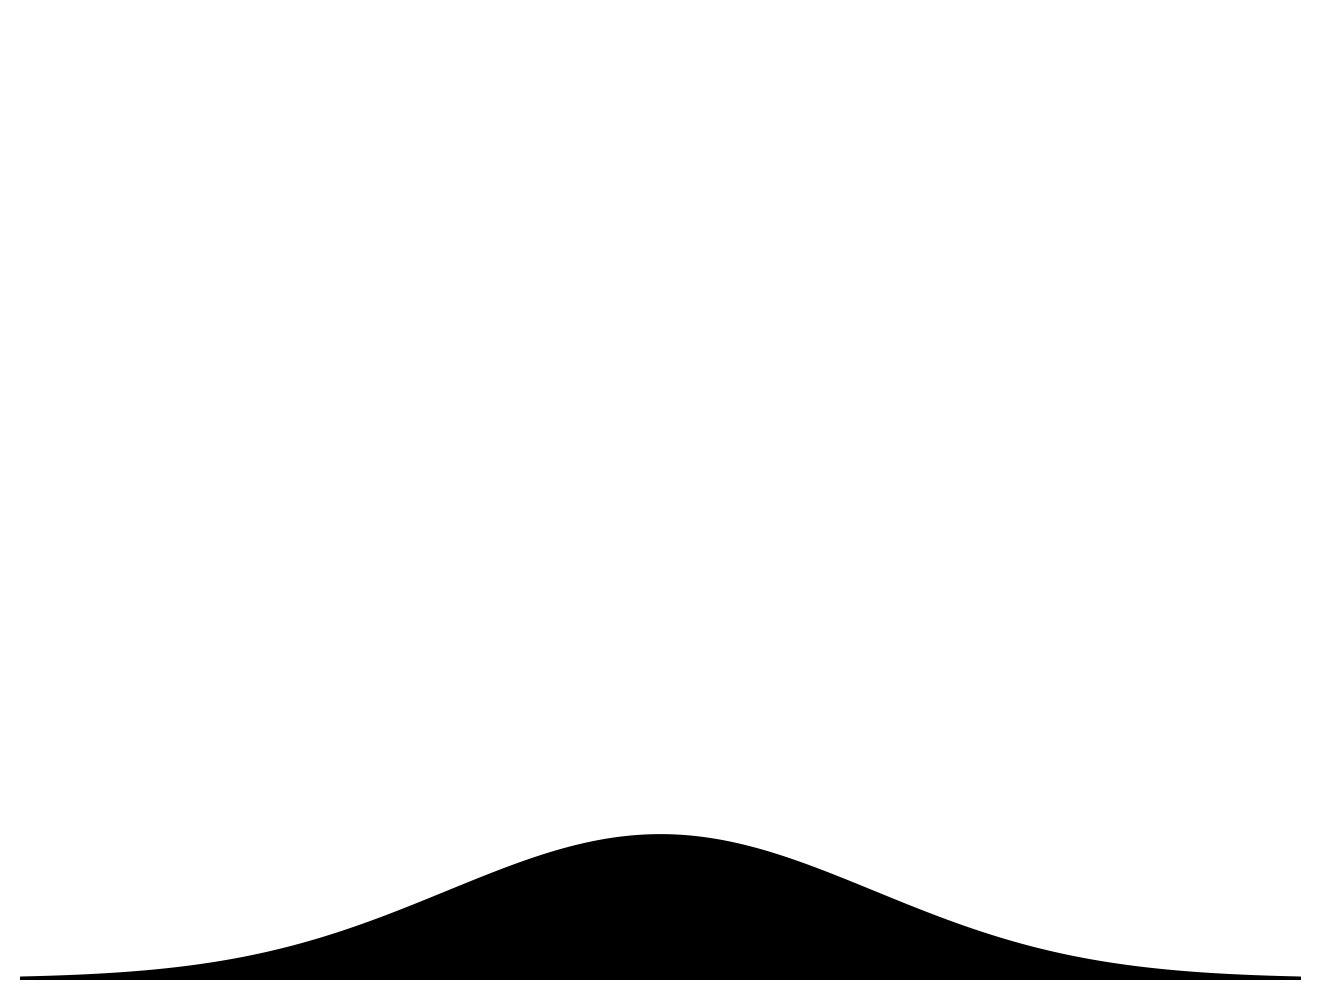

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 3, 400)


def mountain_shape(x):
    
    return 0.15 * np.exp(-0.5*((x)/1)**2) 

height = mountain_shape(x)


plt.figure()
plt.fill_between(x, height, color='black')

# # Add boundaries
# domain_length = x[-1] - x[0]
# boundary_length = domain_length / 10
# boundary_height = 1  # Adjust this value to change the height of the boundaries

# # Left boundary
# plt.fill_between([x[0], x[0] + boundary_length], [0, 0], [boundary_height, boundary_height], color='black')

# # Right boundary
# plt.fill_between([x[-1] - boundary_length, x[-1]], [0, 0], [boundary_height, boundary_height], color='black')


plt.xlim(-3, 3)
plt.ylim(0.0, 1)
plt.axis('off')  
#remove white space at the edge of the figure
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)


plt.savefig('mountain.jpg', format='jpg', dpi=300)  


plt.show()


In [13]:
im0 = image.imread('mountain.jpg')
im0 = np.array(im0)

for i in range(1440):
    for j in range(1920):
        if im0[i][j][0] == 0:
            im0[i][j]=[255,255,255]
        else:
            im0[i][j]=[0, 0, 0]
            
for i in range(1440):
    for j in range(1920):
        if im0[i][j][0] == 0:
            im0[i][j]=[0,0,0]
        else:
            im0[i][j]=[255, 255, 255]
                        
# pad = 90
# im = np.ones((im0.shape[0] + 2*pad, im0.shape[1] + pad, 3))*255
# im[pad:-pad, pad:,:] = im0
# im = im[pad:, pad:, :]

im = np.ones((im0.shape[0] , im0.shape[1], 3))*255
im[:, :,:] = im0
im = im[:, :, :]

In [14]:
def mask(x): return 0.5*(1-erf(np.pi**(1/2)*x))

In [15]:
cell = np.asarray(im)[:,:,2]
cell = 1-(cell-np.min(cell))/(np.max(cell)-np.min(cell)) - .5 # boundary at cell == 0
# the signed distance function
distance = skfmm.distance(cell, dx = Lx/cell.shape[0])

print(cell.shape[1])

1920


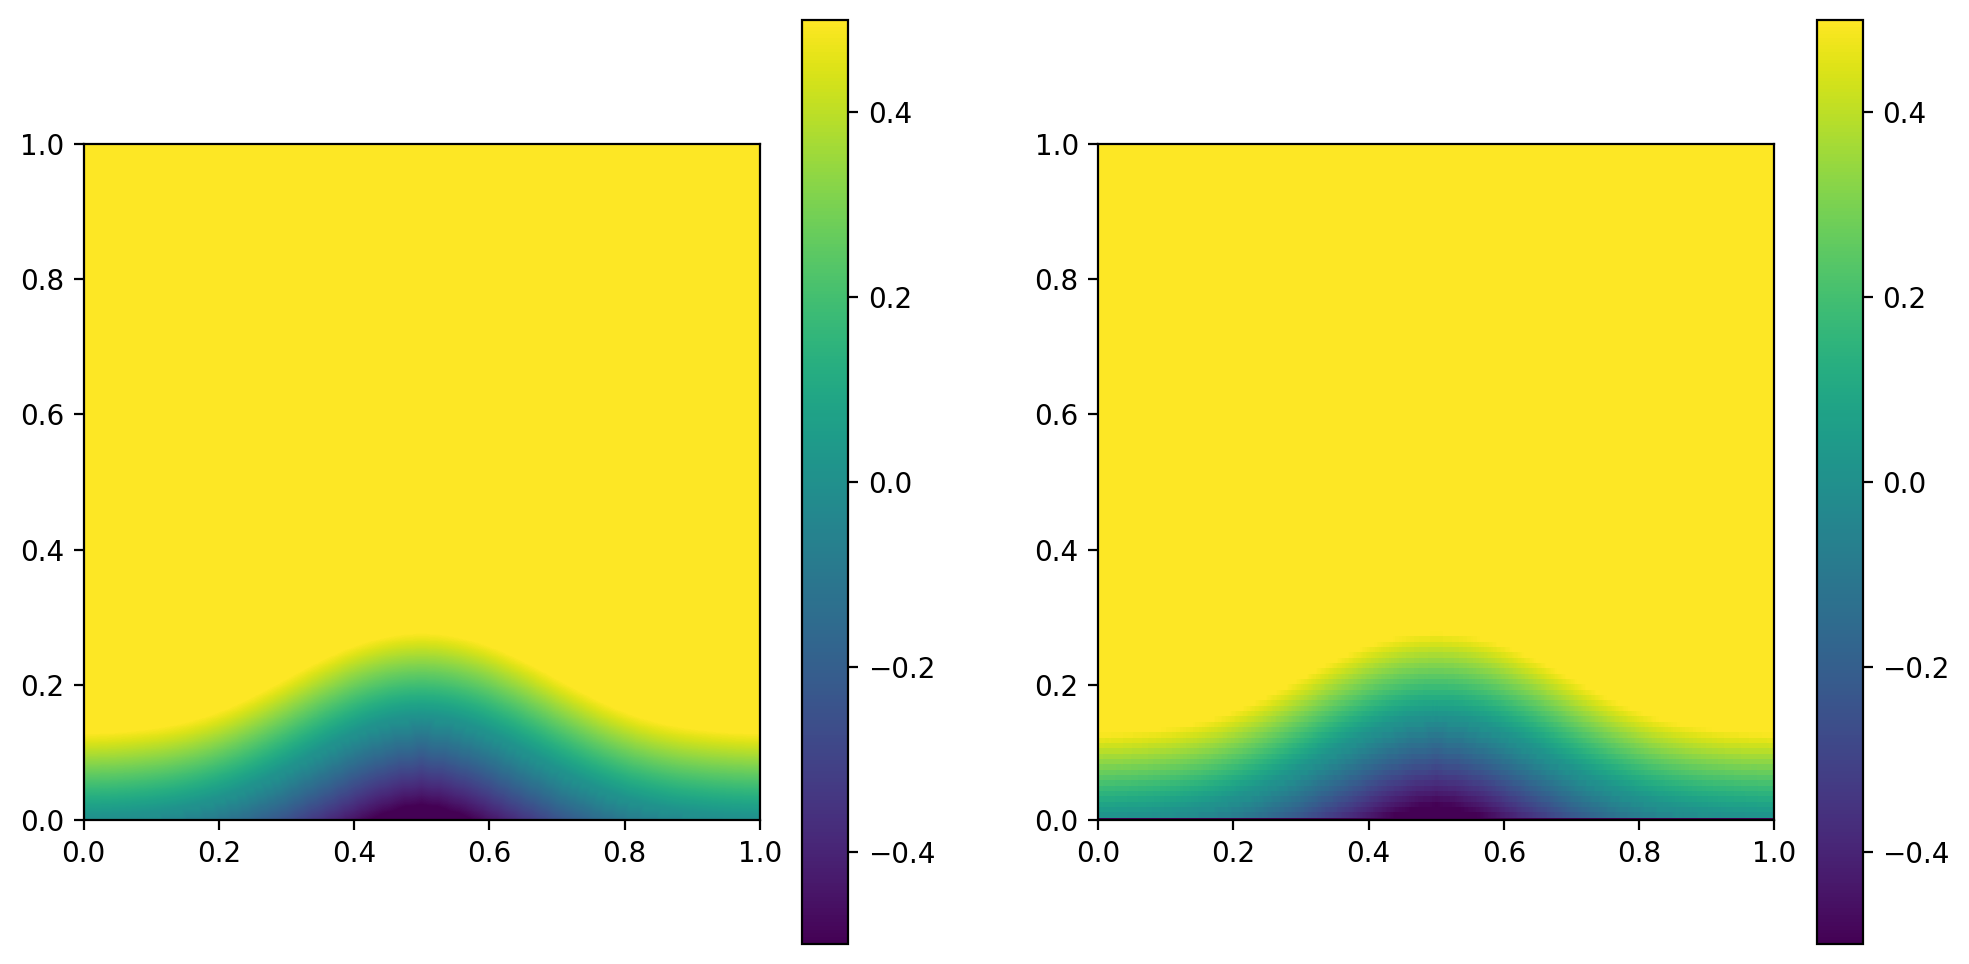

In [16]:
# theta = np.linspace(0, 2.1np.pi, 100)
# x_circ = 0.5+0.5np.cos(theta)
# y_circ = 0.5+0.5*np.sin(theta)

z = 1-np.arange(cell.shape[0])/cell.shape[0]
x = np.arange(cell.shape[1])/cell.shape[1]


# xmesh1, zmesh1 = np.meshgrid(x, z, indexing='ij')
# xmesh1, zmesh1 = dpt.quad_mesh(x, z)

x_hi = np.linspace(0, 1, Nx)
z_hi = np.linspace(0, Lz, Nz)
# xmesh2, zmesh2 = np.meshgrid(x_hi, z_hi, indexing='ij')
distance_func = sci.RegularGridInterpolator((1-z, x), distance, bounds_error=False, fill_value=-0.5)
distance_hi = distance_func((1-z_hi[:,None], x_hi[None,:]))

fig = plt.figure(figsize=[12,6])
ax1 = fig.add_subplot(1,2,1)
mesh1 = ax1.pcolormesh(x, z, distance, shading='auto', vmin=-0.5, vmax=0.5)
plt.colorbar(mesh1)
ax2 = fig.add_subplot(1,2,2)
mesh2 = ax2.pcolormesh(x_hi, z_hi, distance_hi, shading='auto', vmin=-0.5, vmax=0.5)
plt.colorbar(mesh2)

for ax in [ax1, ax2]:
    ax.set_aspect(1)
    # ax.plot(x_circ, y_circ, c='k')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

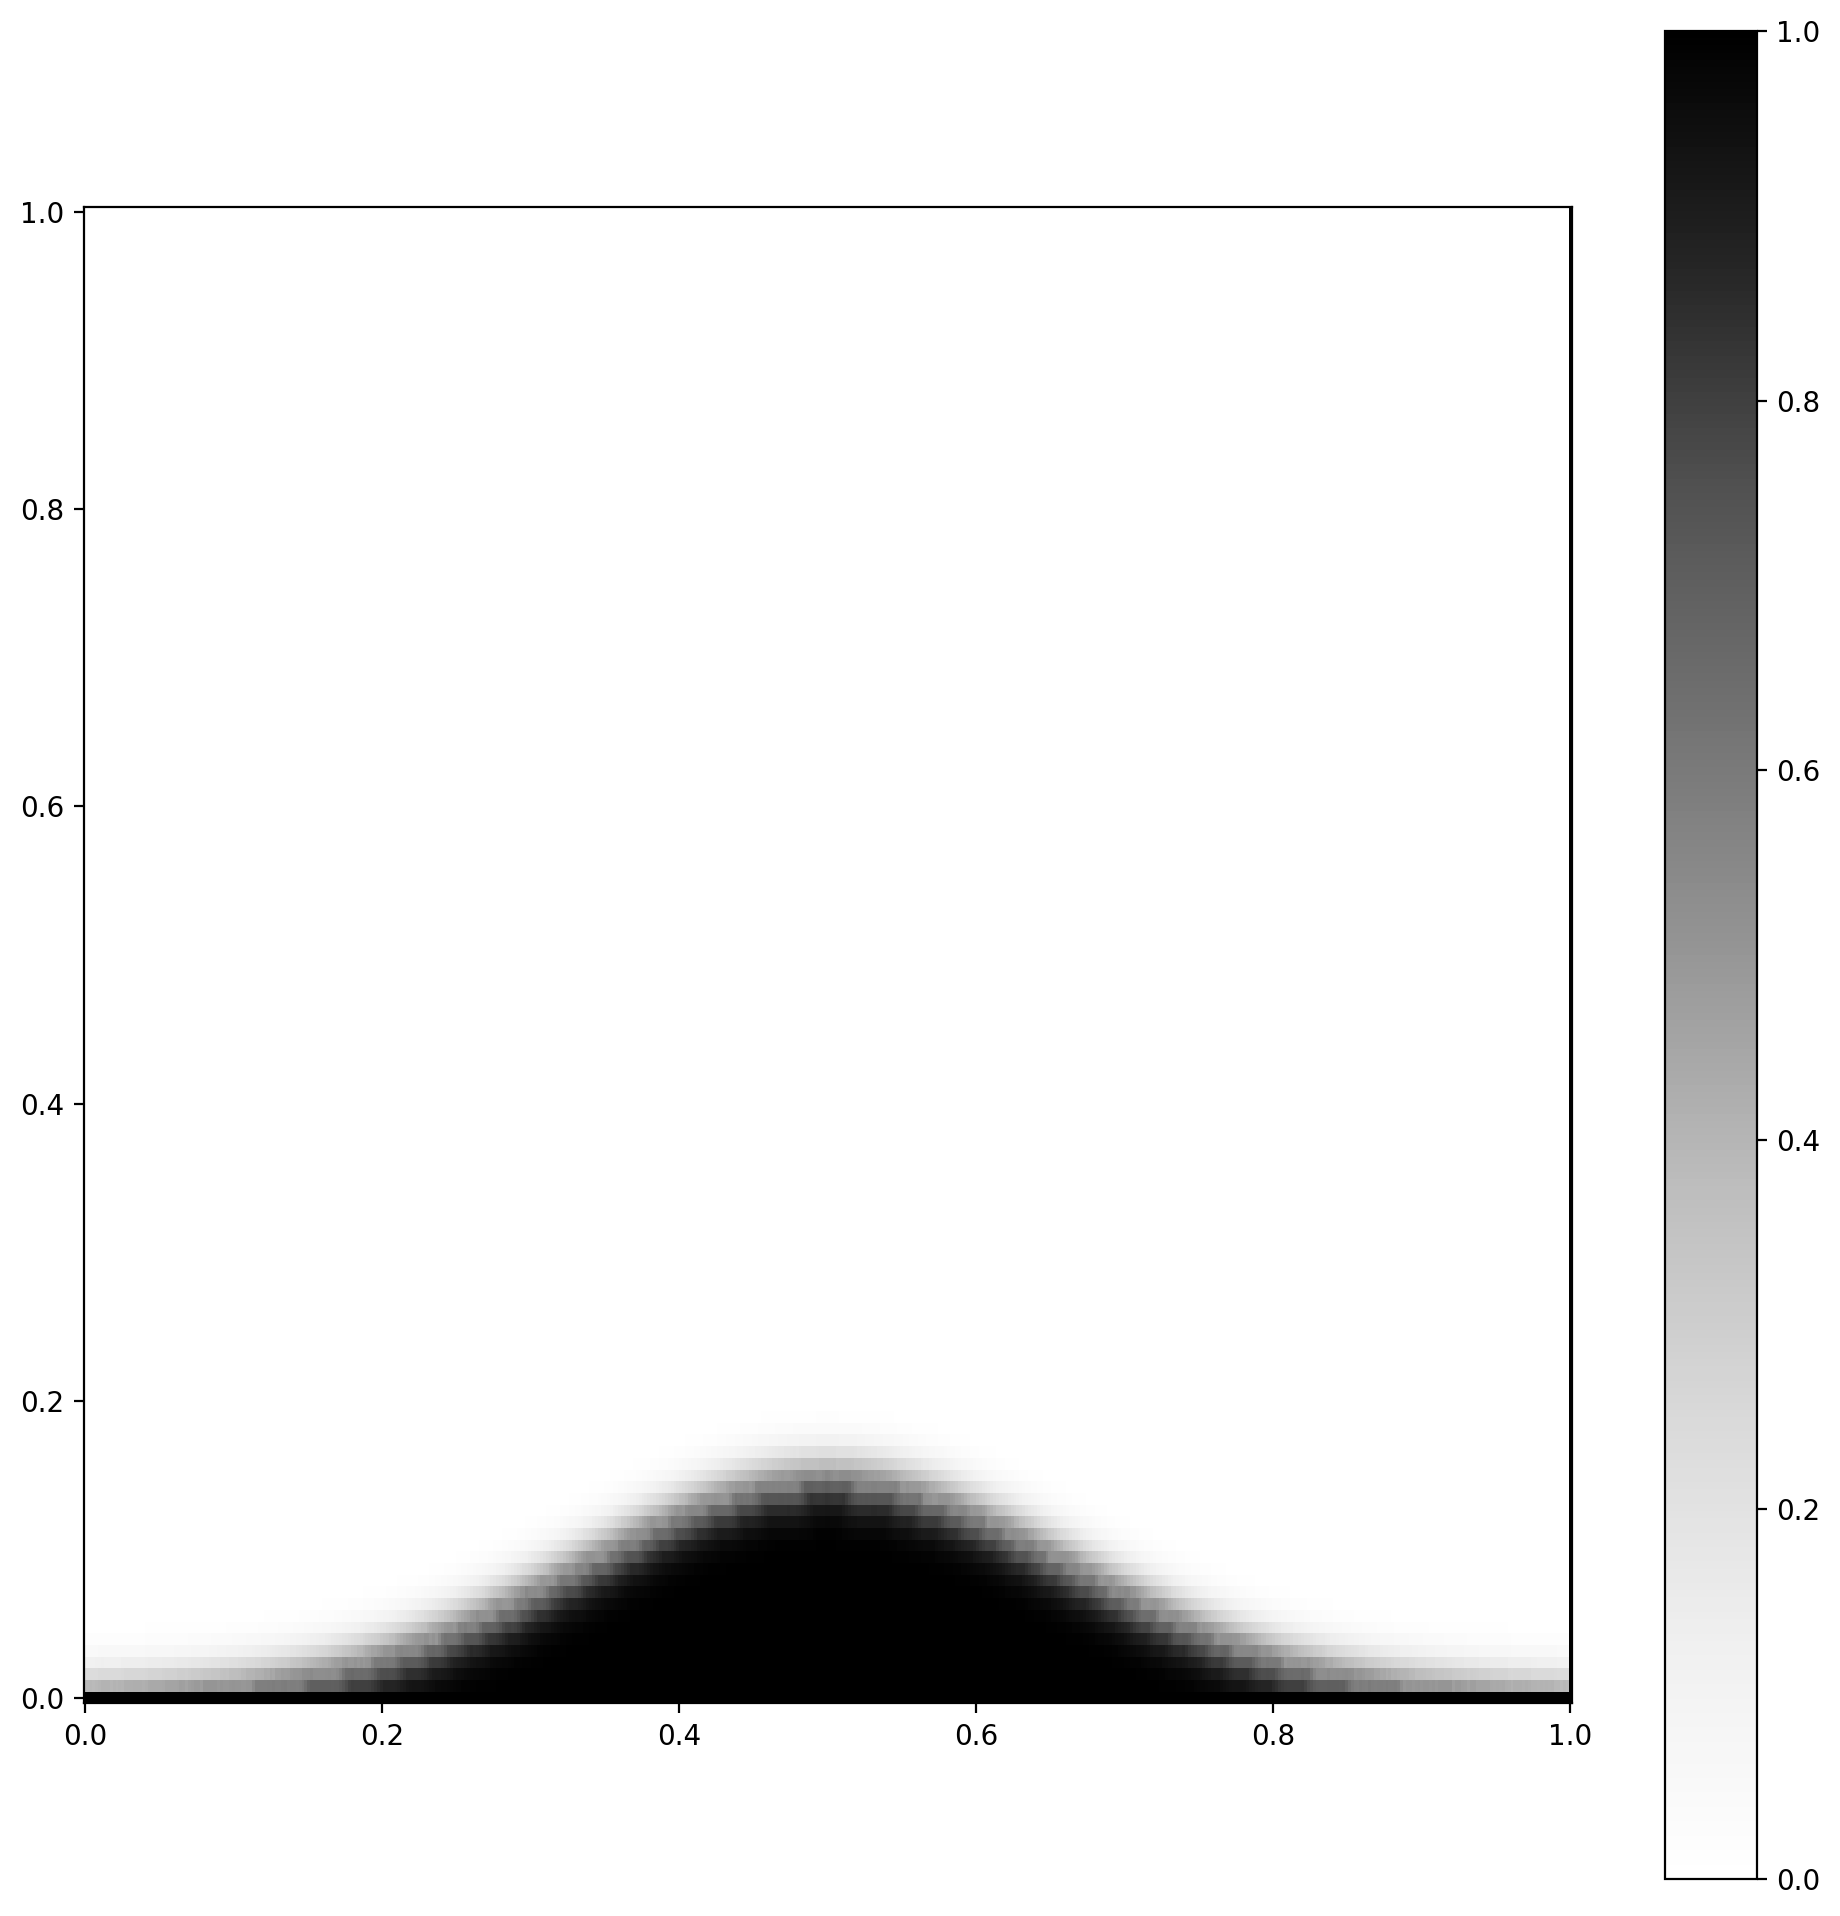

In [17]:

fig, ax = plt.subplots(figsize=[12,12])
plot = ax.pcolormesh(x_hi, z_hi, mask(distance_hi/δ),cmap='Greys')
ax.set(aspect=1)
plt.colorbar(plot,ax=ax)

Interpolation time: 0.01 seconds
Mask grid shape: (768, 192)


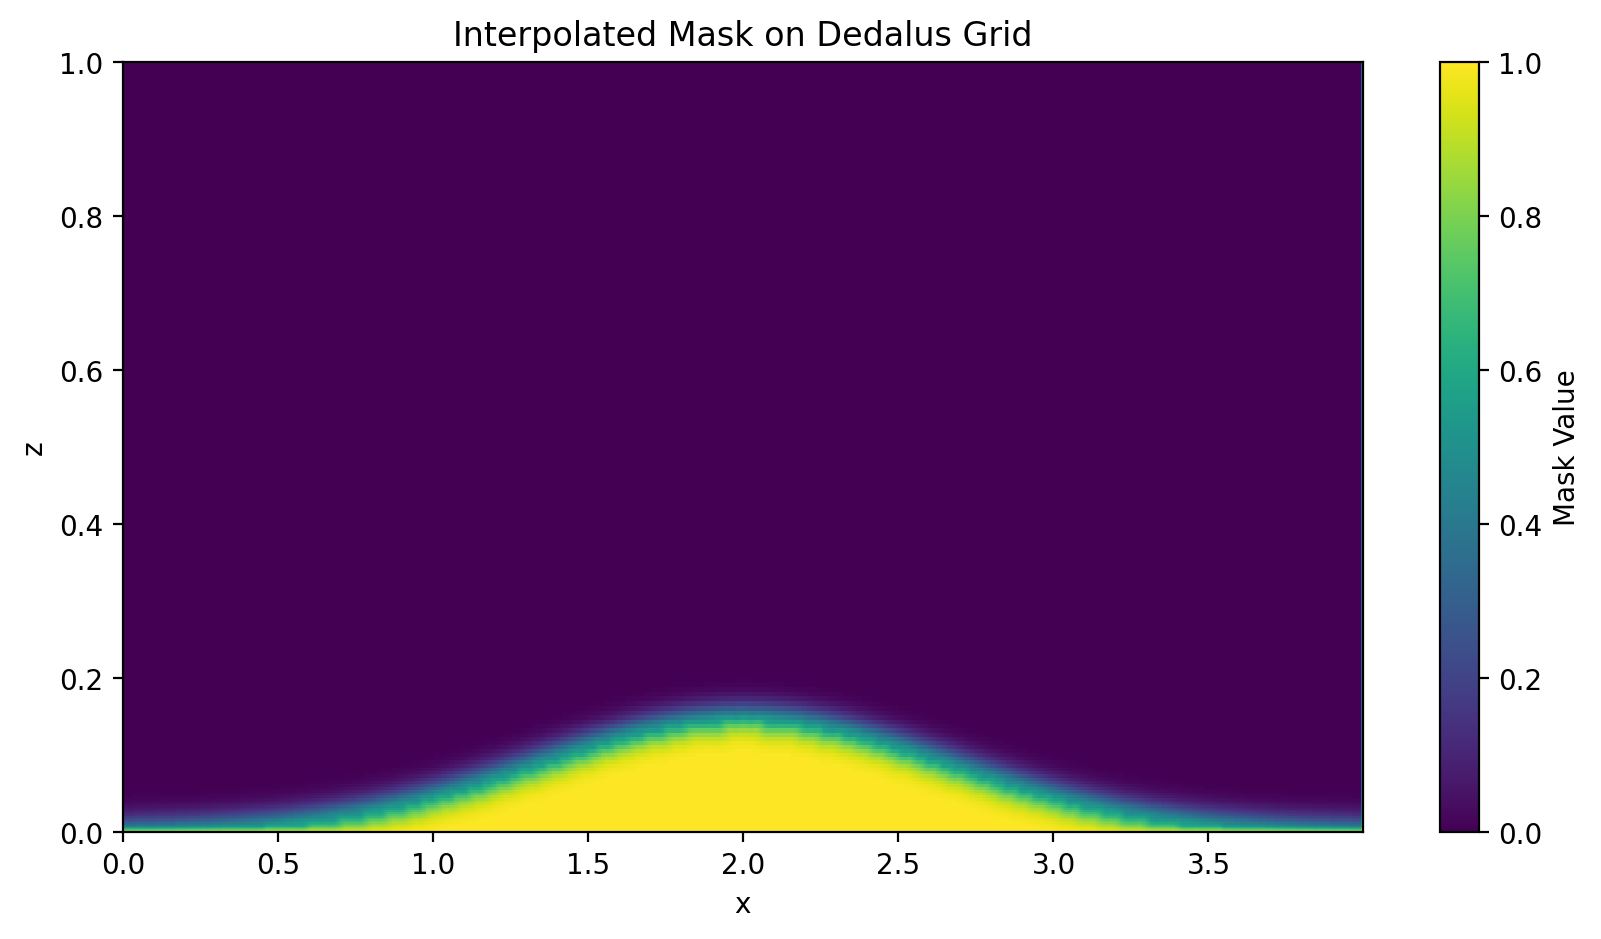

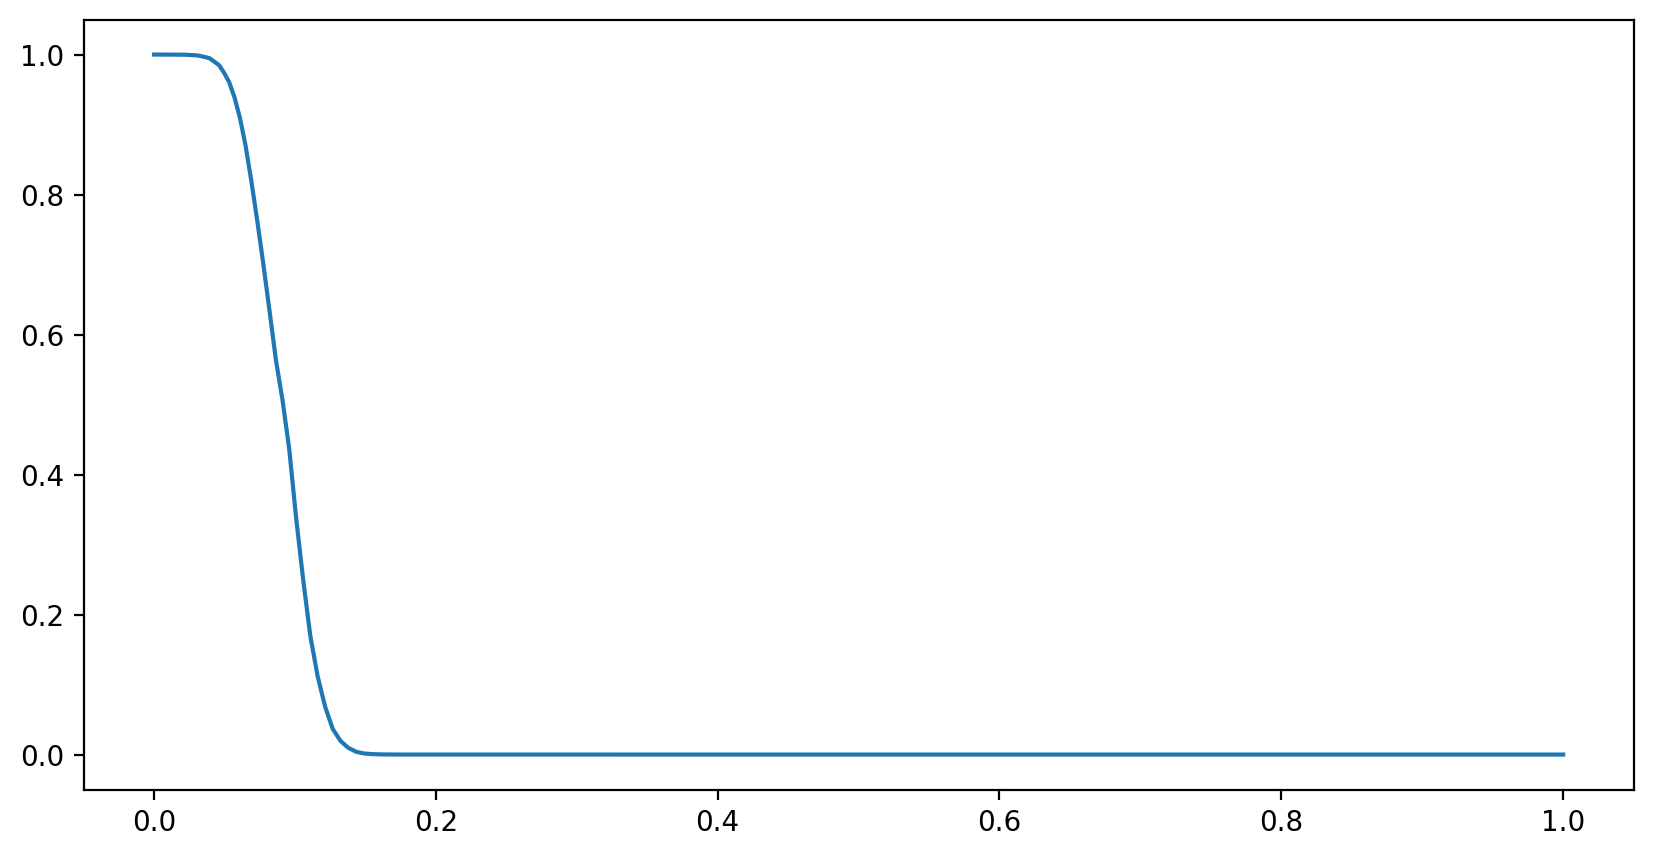

In [18]:
import numpy as np
import scipy.interpolate as sci
import dedalus.public as d3
import time

# Assuming Nx, Nz, Lx, Lz, distance_hi, δ are defined earlier in your code

dtype = np.float64
dealias = 3/2

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Create high-resolution coordinates
x_hi = np.linspace(0, Lx, distance_hi.shape[1])
z_hi = np.linspace(Lz, 0, distance_hi.shape[0])  # Reversed to match your original setup

# Define mask function
# def mask(x):
#     return 0.5 * (1 - np.tanh(x))  # Example mask function, adjust as needed

def mask(x): return 0.5*(1-erf(np.pi**(1/2)*x))

# Create interpolation function
interp_smooth = sci.RegularGridInterpolator((z_hi, x_hi), mask(distance_hi/δ), 
                                            bounds_error=False, fill_value=1, method='linear')

# Create mask field
mask_grid = dist.Field(name='mask', bases=(xbasis, zbasis))

# Interpolate mask onto Dedalus grid
mask_grid.change_scales(dealias)
xg = dist.local_grid(xbasis, scale=dealias)
zg = dist.local_grid(zbasis, scale=dealias)

start_time = time.time()

# Vectorized interpolation
X, Z = np.meshgrid(xg[:, 0], zg[0, :], indexing='ij')
mask_grid['g'] = interp_smooth((Lz - Z, X))  # Note the Lz - Z to flip the z-axis

end_time = time.time()

print(f"Interpolation time: {end_time - start_time:.2f} seconds")
print(f"Mask grid shape: {mask_grid['g'].shape}")

# Optionally, visualize the mask
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.pcolormesh(xg[:, 0], zg[0, :], mask_grid['g'].T, shading='auto')
plt.colorbar(label='Mask Value')
plt.title('Interpolated Mask on Dedalus Grid')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(zg[0,:], mask_grid['g'][Nx//2,:].T)
plt.show()

In [19]:
import h5py
# with h5py.File('masks/mask_sp.h5', 'w') as f:
#     f['mask'] = mask_grid['g']
#     f['x'] = x
#     f['z'] = z
    
with h5py.File('masks/mask.h5', 'w') as f:
    f['mask'] = mask_grid['g']
    f['x'] = x
    f['z'] = z

ValueError: not enough values to unpack (expected 2, got 0)

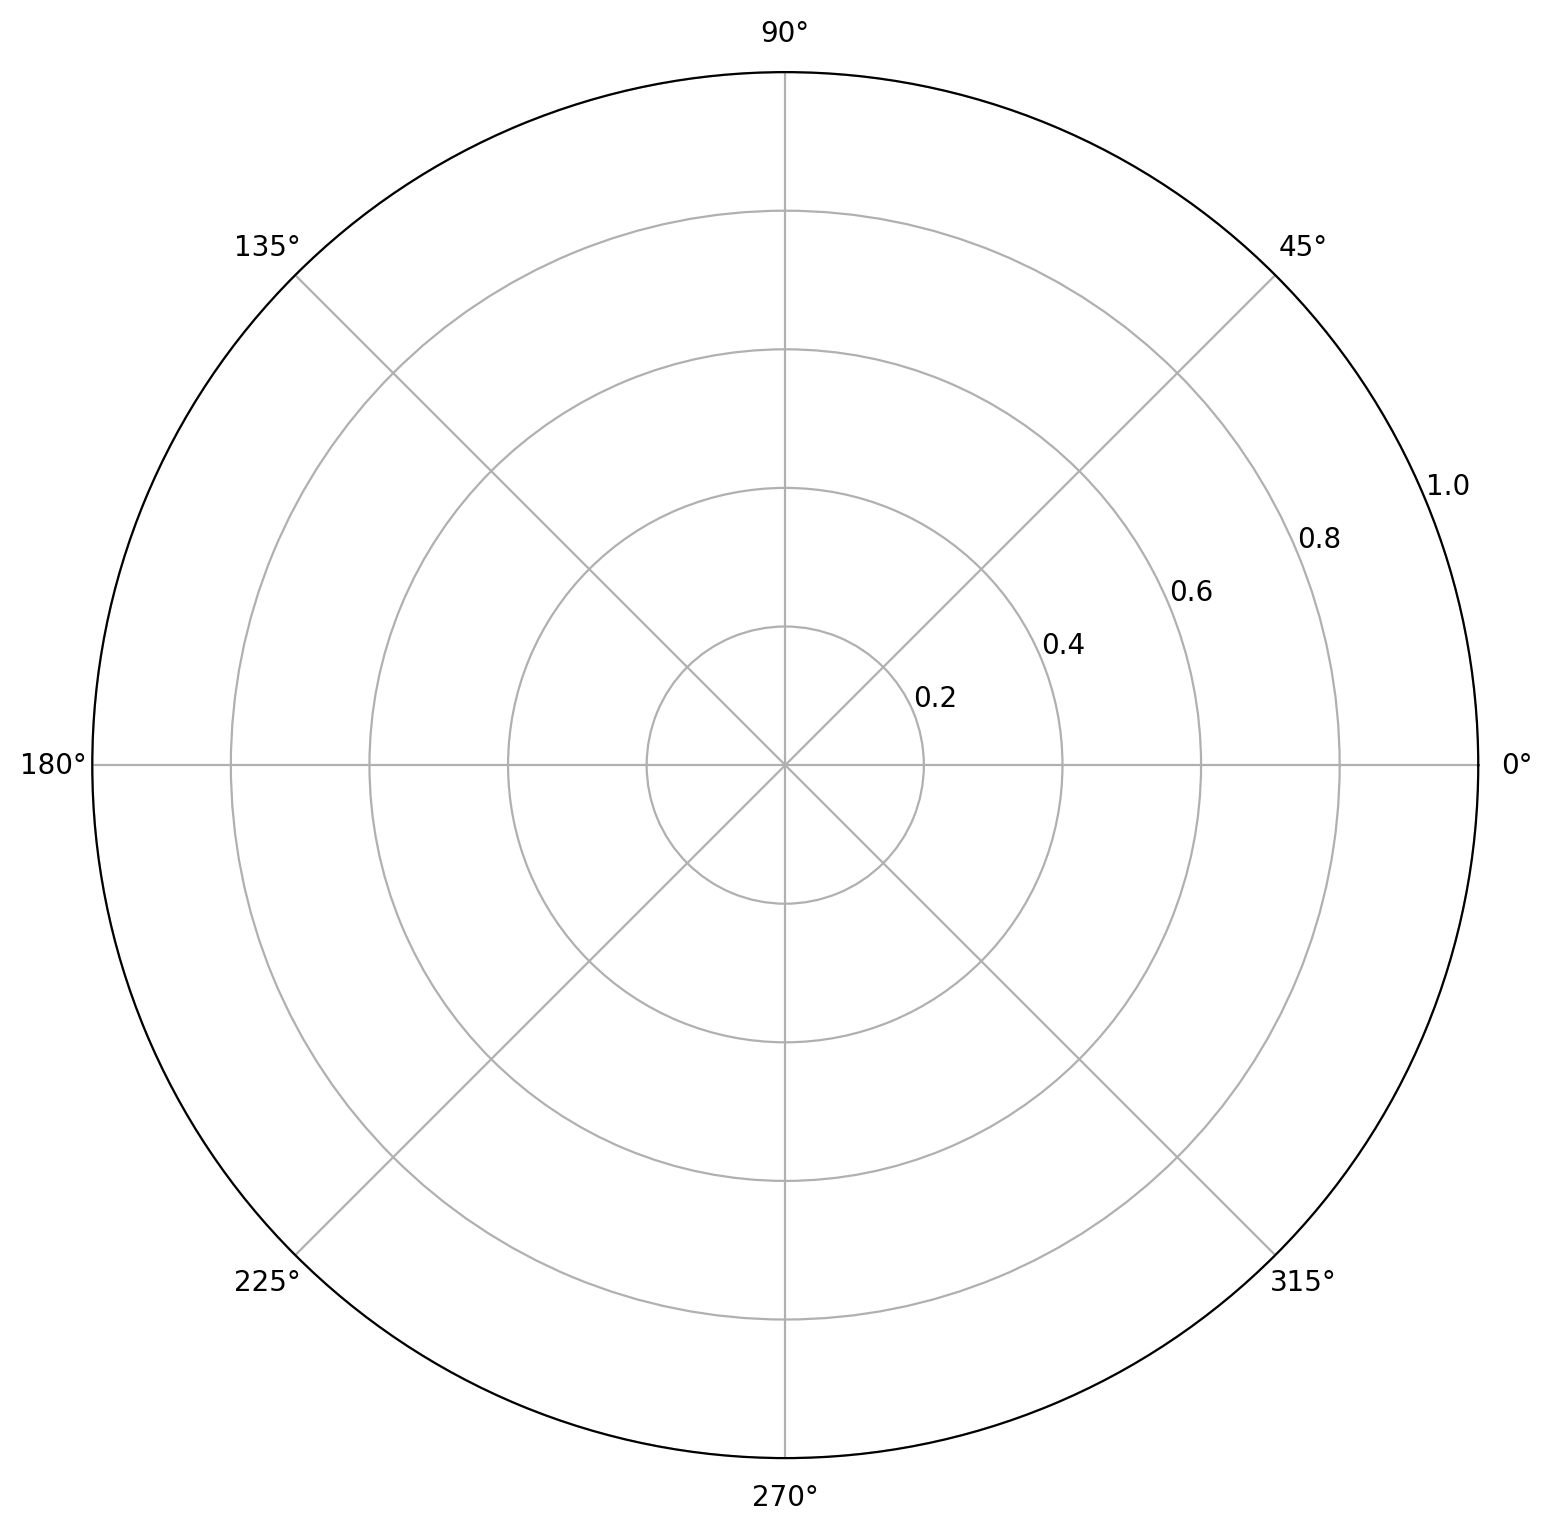

In [20]:
fig = plt.figure(figsize=[9,9])
ax = fig.add_subplot(1,1,1, polar=True)
ax.pcolormesh(zg, xg, mask_grid, shading='auto')

In [ ]:

start_time = time.time()
# xvals = 1-(r*(np.cos(phi+np.pi/2)) + 1)/2
# yvals = (r*(np.sin(phi+np.pi/2)) + 1)/2
end_time = time.time()
print('elapsed seconds for interp: {}'.format(end_time - start_time))

ValueError: Method '1.6733041299454854e-05' is not defined

# Old Attempts to figure out proper mask interp

In [ ]:
# interp_smooth = sci.interp2d(x_hi,y_hi,mask(distance_hi/δ))
# start_time = time.time()
# for i in range(phi.shape[0]):
#     for j in range(r.shape[1]):
        
#         xl = (r[0,j]*(np.cos(phi[i,0])) + 1)/2
#         yl = (r[0,j]*(np.sin(phi[i,0])) + 1)/2
#         mask_grid[i,j] = interp_smooth(xl, yl)
# end_time = time.time()

In [ ]:

# mask_grid_2 = np.zeros_like(mask_grid)
# start_time_2 = time.time()
# print(r.shape)
# xvals = (r*(np.cos(phi+np.pi/2)) + 1)/2
# yvals = (r*(np.sin(phi+np.pi/2)) + 1)/2
# print(xvals[10, 10], yvals[10, 10])
# mask_grid_2[:] = interp_smooth((1-xvals, yvals))
# end_time_2 = time.time()
# fig = plt.figure(figsize=[9,9])
# ax = fig.add_subplot(1,1,1, polar=True)
# ax.pcolormesh(pp, rr, mask_grid_2, shading='auto')

In [ ]:
# print(end_time - start_time)
# print(end_time_2 - start_time_2)
# print(np.abs(mask_grid - mask_grid_2).max())